# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import fit_linP
import likelihood

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_15052019/'
p1d_label='p1d'
skewers_label='Ns110_wM0.1'
use_gp=False
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1000,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [5]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0','ln_tau_1','Delta2_star','n_star']

In [6]:
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
likelihood setup with 4 free parameters
4 free parameters


In [7]:
for p in like.free_params:
    print(p.name,p.value)

Delta2_star 0.360175905286
n_star -2.29933566726
ln_tau_0 -0.794580172414
ln_tau_1 3.18


In [8]:
like.go_silent()

### Setup MCMC to call this function

In [9]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
def setup_walkers(ndim,nwalkers,like,verbose=False):
    print('setup %d walkers with %d dimensions'%(nwalkers,ndim))
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    # make sure that all walkers are within the convex hull
    for iw in range(nwalkers):
        walker=p0[iw]
        if verbose: print(iw,'walker',walker)
        test=log_prob(walker,like)
        while (test == -np.inf):
            if verbose: print(iw,'bad walker',walker)
            walker = np.random.rand(ndim)
            if verbose: print(iw,'try walker',walker)
            test=log_prob(walker,like)
        if verbose: print(iw,'good walker',walker,' log_prob=',test)
        p0[iw]=walker
    return p0

In [11]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=len(like.free_params)
# setup initial walkers
nwalkers = 30

In [12]:
p0=setup_walkers(ndim,nwalkers,like)

setup 30 walkers with 4 dimensions


In [13]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [14]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos[0],prob[0])

finished burn-in at [ 0.51895068  0.13318992  0.63325531  0.61849317] -1927.00583503


In [15]:
# reset and run actual chains
sampler.reset()
nsteps=300
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0][0])

0 [ 0.51895068  0.13318992  0.63325531  0.61849317]
20 [ 0.50779042  0.13076306  0.61551131  0.65036966]
40 [ 0.46953006  0.12834853  0.61817187  0.63804824]
60 [ 0.46896622  0.12568735  0.62150863  0.6530445 ]
80 [ 0.47181187  0.12026935  0.61841946  0.64766623]
100 [ 0.48149991  0.11813984  0.61282549  0.65031926]
120 [ 0.45528951  0.12343024  0.6307618   0.64301957]
140 [ 0.44385258  0.12922563  0.62691895  0.6481971 ]
160 [ 0.46314087  0.12357667  0.62394892  0.65067147]
180 [ 0.44514009  0.12775915  0.62204192  0.65191884]
200 [ 0.46904776  0.12246799  0.61389809  0.65103845]
220 [ 0.47274851  0.11985098  0.61293574  0.64564604]
240 [ 0.47632973  0.12275287  0.61317032  0.64867892]
260 [ 0.46243582  0.1257331   0.61752679  0.63952372]
280 [ 0.47380183  0.12561005  0.60317026  0.66645701]


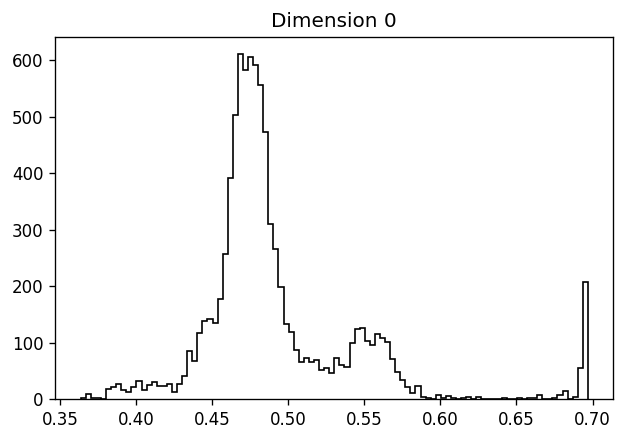

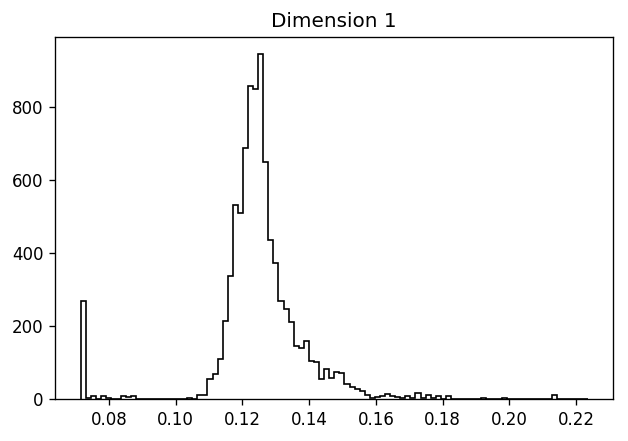

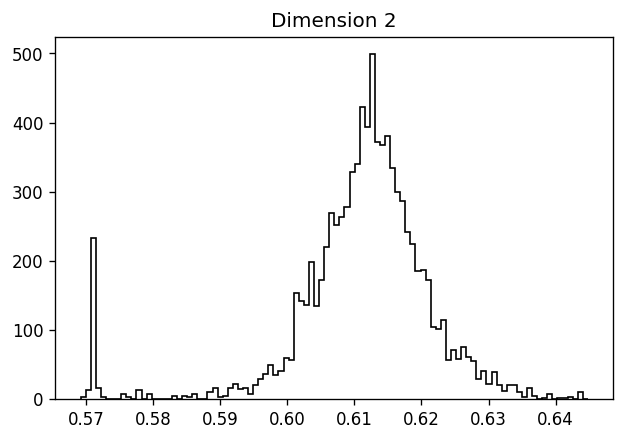

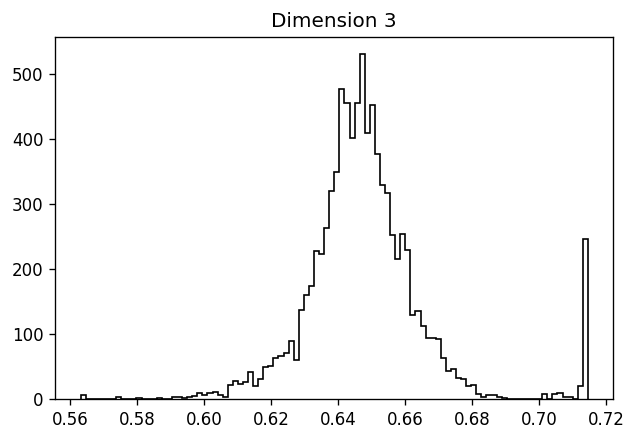

In [16]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.483


### Use likelihood object to make several useful plots

In [18]:
# get mean of chain
mcmc_mean=np.mean(sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.49195871  0.12521304  0.61123263  0.6481214 ]


In [19]:
like.update_parameters(mcmc_mean)

In [20]:
for p in like.free_params:
    print(p.name,p.value)

Delta2_star 0.323793806915
n_star -2.33747869561
ln_tau_0 -0.894383684192
ln_tau_1 4.29624280947


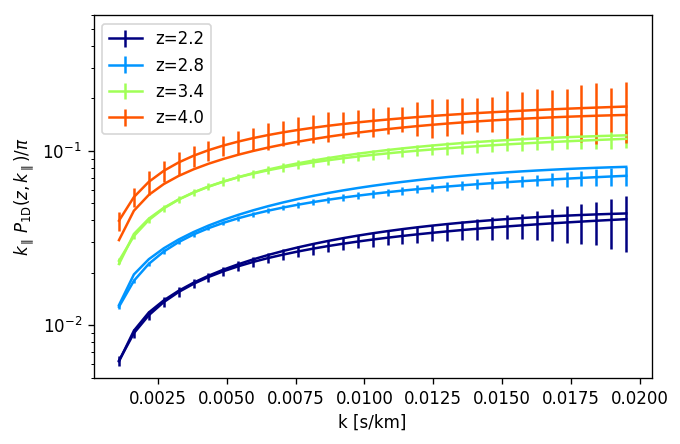

In [21]:
like.plot_p1d()

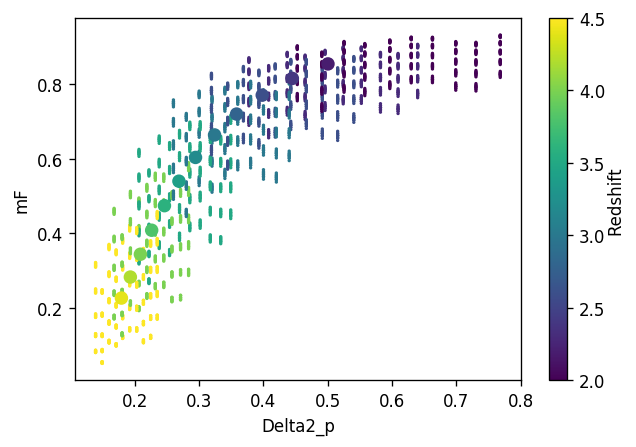

In [22]:
like.overplot_emulator_calls('Delta2_p','mF')

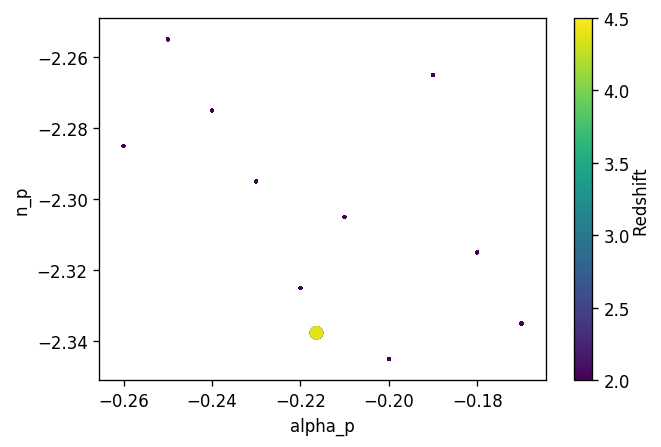

In [23]:
like.overplot_emulator_calls('alpha_p','n_p')

### Make contour plots using corner.py

In [24]:
labels=[]
for p in like.free_params:
    labels.append(p.name)

In [25]:
# get normalized parameter values (chains are constrained in 0<x<1)
values=np.array([like.free_params[ip].value_from_cube(sampler.flatchain[:,ip]) for ip in range(len(like.free_params))]).transpose()

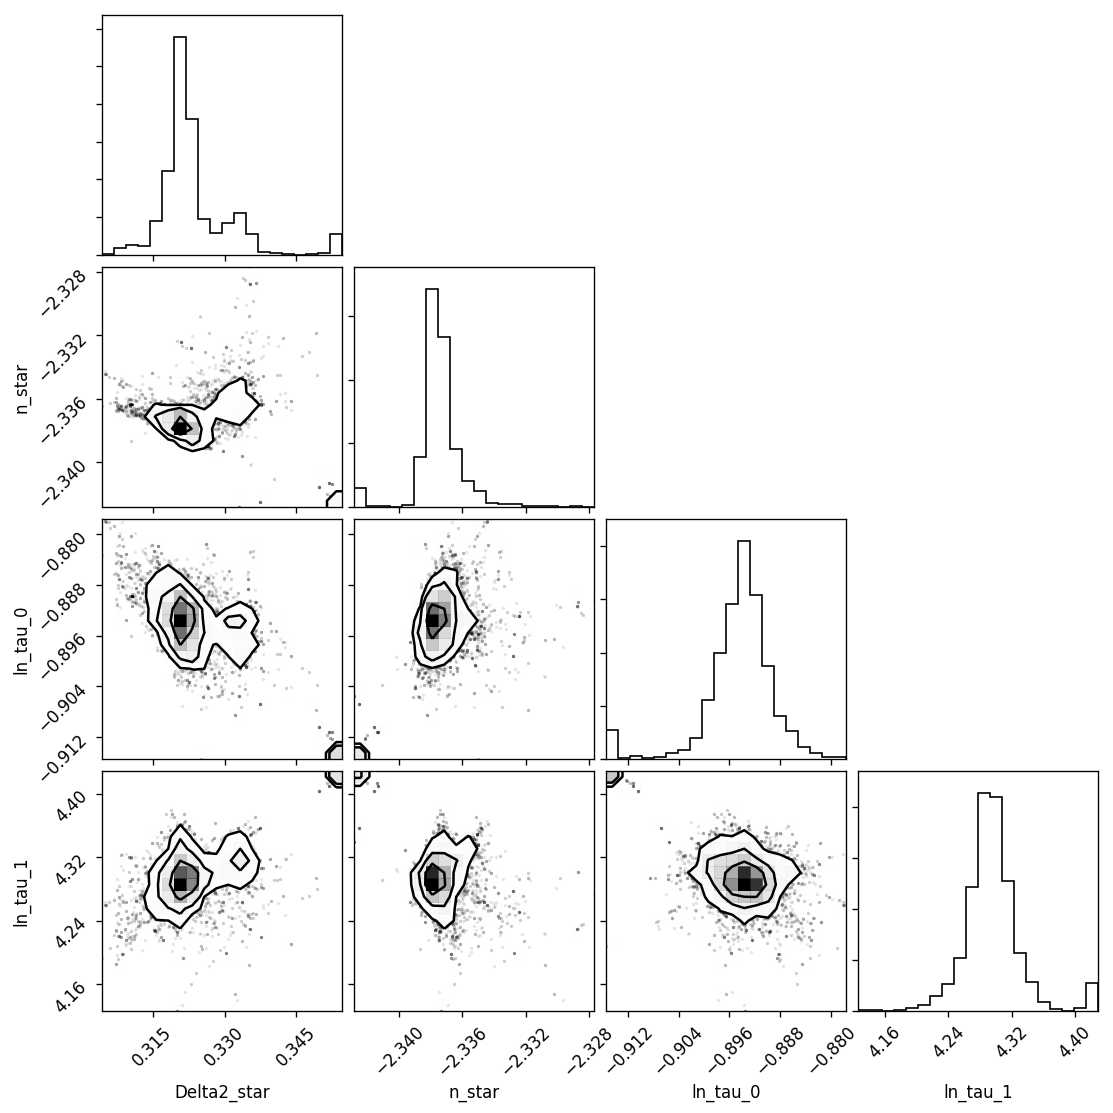

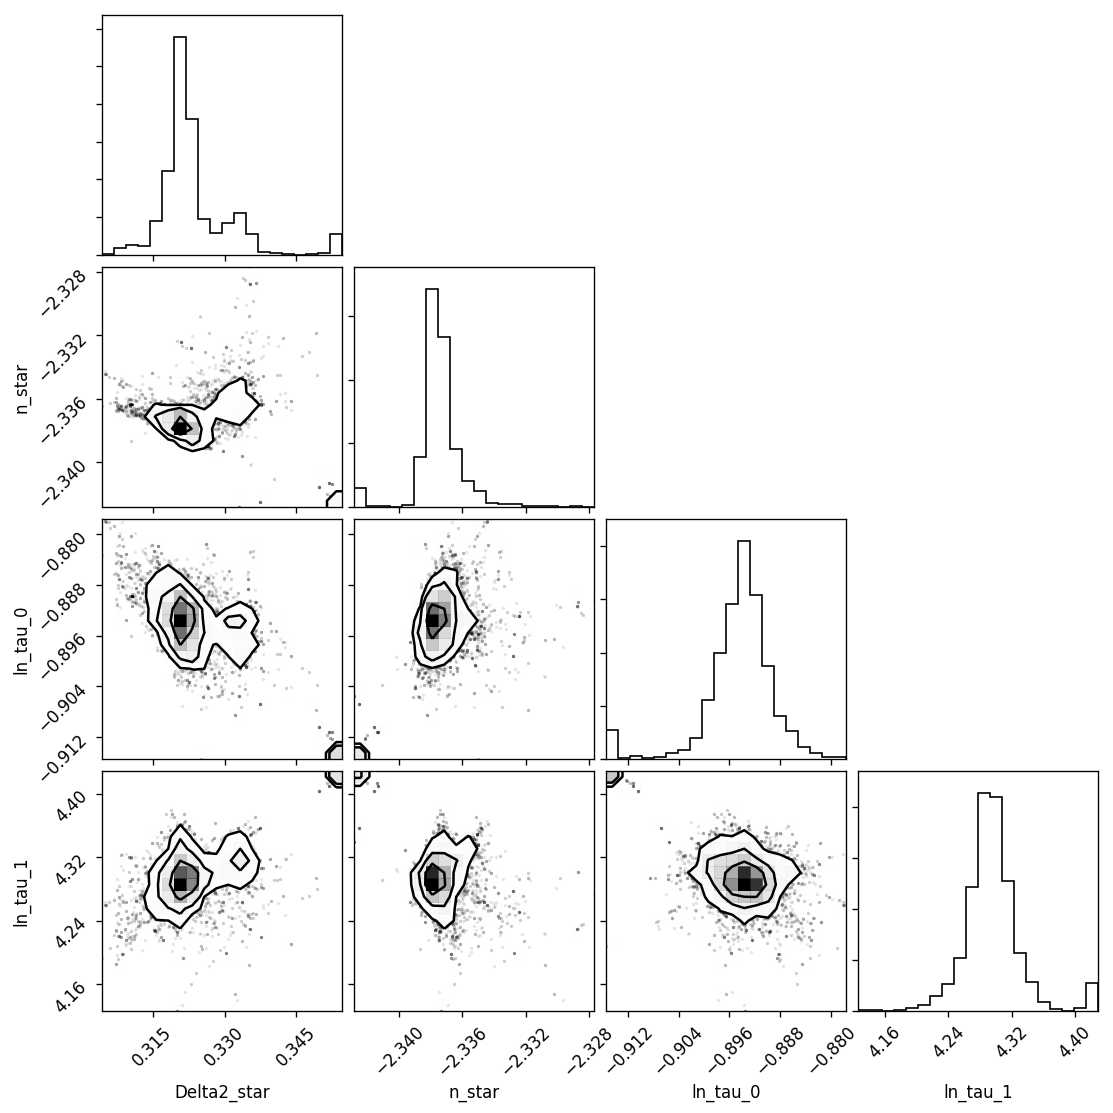

In [26]:
corner.corner(values,labels=labels)